From https://www.sciencedirect.com/science/article/pii/S030440762100227X#appSB

# Scalable Inference for stochastic volatility.
## Implementation of the Feynman Kac model describing the transition dynamics in the above paper

In [1]:
import jax.random as jr
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal, norm
from jax import jit, vmap, Array, lax
import jax

from dynamax.linear_gaussian_ssm import lgssm_filter
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

import matplotlib.pyplot as plt

from feynmac_kac.protocol import FeynmacKac, PFConfig
from feynmac_kac.bootstrap import BootstrapParticleFilter
from utils.datasets import load_dataset


In [2]:

def givens_rotation(D, i, j, omega):
    """
    Create an n x n Givens rotation matrix that rotates in the (i, j) plane.

    Parameters:
        D (int): Dimension of the square matrix.
        i (int): First index (0-based).
        j (int): Second index (0-based).
        omega (float): Rotation angle in radians.

    Returns:
        jnp.ndarray: Givens rotation matrix.
    """
    
    # Start with identity
    G = jnp.eye(D)
    c = jnp.cos(omega)
    s = jnp.sin(omega)

    # Apply rotation in (i, j) plane
    G = G.at[i, i].set(c)
    G = G.at[j, j].set(c)
    G = G.at[i, j].set(s)
    G = G.at[j, i].set(-s)

    return G


@jit
def givens_product(w_ij: Array):
    """
    w_ij: (D, D) angles; we use only strict upper-triangle (i<j).
    
    Returns:
        P: (D, D) product G_{(0)} @ G_{(1)} @ ... @ G_{(M-1)}
    """
    
    D = w_ij.shape[0]
    i_idx, j_idx = jnp.triu_indices(D, k=1)          # vectors of length M
    omegas = w_ij[i_idx, j_idx]                       # (M,)

    # construct Givens matrices over all (i,j,omega)
    G_all = vmap(
        lambda ii, jj, om: givens_rotation(D, ii, jj, om),
        in_axes=(0, 0, 0)
    )(i_idx, j_idx, omegas)

    # multiply all Givens matrices
    P = lax.associative_scan(lambda A, B: A @ B, G_all)[-1]
    return P

# def givens_product(w_ij: Array) -> Array:
#     """
#     Compute product of Givens rotations from angle matrix w_ij (K×K).
#     No vmaps over indices — uses lax.fori_loop for stability and jit safety.
#     """
#     D = w_ij.shape[0]
#     i_idx, j_idx = jnp.triu_indices(D, k=1)
#     omegas = w_ij[i_idx, j_idx]

#     def body_fun(k, P):
#         i, j = i_idx[k], j_idx[k]
#         omega = omegas[k]

#         c = jnp.cos(omega)
#         s = jnp.sin(omega)
#         G = jnp.eye(D)
#         G = G.at[i, i].set(c)
#         G = G.at[j, j].set(c)
#         G = G.at[i, j].set(s)
#         G = G.at[j, i].set(-s)
#         return P @ G

#     # Start from identity, apply each rotation
#     P = lax.fori_loop(0, omegas.shape[0], body_fun, jnp.eye(D))
#     return P


def invert_transform(delta):
    """ Invert transform delta to (-pi/2, pi/2) for Givens rotation angle """
    
    return (jnp.pi / 2) * (jnp.exp(delta) - 1) / (jnp.exp(delta) + 1)


In [15]:

class MSVStochVol(FeynmacKac):
    def __init__(self, params):
        super().__init__(params)

        # self.vmapped_invert_transform = vmap(lambda delta: invert_transform(delta))
        # self.vmapped_givens_product = vmap(lambda omega: givens_product(omega))
        # self.vmapped_diag_exp = vmap(lambda h: jnp.diag(jnp.exp(h)))
        # self.vmapped_S_from_SVD = vmap(lambda Pt, Lt: Pt @ Lt @ Pt.T)

    def p0(self, key, N):
        """
        Initial points sampled from normals using hyper-parameters h0 and d0
        """
        
        h0 = self.params["h0"]
        d0 = self.params["d0"]
        phi_h = self.params["phi_h"]
        phi_d = self.params["phi_d"]
        sigma_h = self.params["sigma_h"]
        sigma_d = self.params["sigma_d"]

        K = h0.shape[0]
        
        key, key_h1, key_d1 = jr.split(key, 3)
        h1 = h0 + (sigma_h / jnp.sqrt(1.0 - phi_h**2)) * jr.normal(key_h1, shape=(N, K))
        d1 = d0 + (sigma_d / jnp.sqrt(1.0 - phi_d**2)) * jr.normal(key_d1, shape=(N, K, K))
        d1 = d1 * jnp.triu(jnp.ones((K, K), dtype=d1.dtype), k=1)  # keep only i<j

        # sample factors
        keys = jr.split(key, N)
        f1 = vmap(lambda k, d, h: self.sample_factors(k, d, h))(keys, d1, h1)
        
        return (h1, d1, f1)

    def pt(self, key, x_prev, t):
        """
        Latent Gaussian transitions for h and d which are transformed variables of rotation angles
        and eigenvalues respectively
            
        1. Sample latent gaussian transitions ht, dt
        2. Calculate the covariance matrix St
        3. Sample the latent factors ft
        """

        h_prev, d_prev, f_prev = x_prev
        h0 = self.params["h0"]
        d0 = self.params["d0"]
        phi_h = self.params["phi_h"]
        phi_d = self.params["phi_d"]
        sigma_h = self.params["sigma_h"]
        sigma_d = self.params["sigma_d"]
        
        K = h_prev.shape[0]
        
        key, key_eta_h, key_eta_d = jr.split(key, 3)
        eta_ht = jr.normal(key_eta_h, shape=(K))
        eta_dt = jr.normal(key_eta_d, shape=(K, K))

        ht = h0 + phi_h * (h_prev - h0) + sigma_h * eta_ht
        dt = d0 + phi_d * (d_prev - d0) + sigma_d * eta_dt
        dt = dt * jnp.triu(jnp.ones((K, K), dtype=dt.dtype), k=1)

        # sample factors
        ft = self.sample_factors(key, dt, ht)
        
        return (ht, dt, ft)

    def log_g(self, t, x_t, x_prev, y_t):
        """
        Evaluate emission likelihood N(B @ ft, V)
        """
        B = self.params["B"]
        V = self.params["V"]

        _, _, ft = x_t

        # evaluate on returns y_t
        return multivariate_normal.logpdf(y_t, mean = B @ ft, cov=V)
        # B = self.params["B"]
        # V = self.params["V"]
        
        # ht, dt, _ = x_t
        # St = self.covariance(ht, dt)              # (K, K)
        # Sigma_y = B @ St @ B.T + V                  # (D, D)
        
        # return multivariate_normal.logpdf(y_t, jnp.zeros(B.shape[0]), Sigma_y)
            
    def log_f(self, t, x_t, y_t):
        return self.log_g(t, x_t, None, y_t)
    
    def log_pt(self, t, x_t, x_prev):
        """
        Evaluate the transition probability

        1. Calculate covariance matrix from x_prev
        2. Evaluate using known factors in x_t
        3. Multiply with the latent Gaussian transition probability
        """

        # h0 = self.params["h0"]
        # d0 = self.params["d0"]
        # phi_h = self.params["phi_h"]
        # phi_d = self.params["phi_d"]
        # sigma_h = self.params["sigma_h"]   # (K,) 
        # sigma_d = self.params["sigma_d"]    # (K, K)

        # h_prev, x_prev, f_prev = x_prev
        # ht, dt, ft = x_t
        # N, K = ht.shape[0], ht.shape[1]

        # # calculate the product of univariate Gaussian transition probabilities
        # mean_h = h0 + phi_h * (h_prev - h0)   # (N, K)
        # log_pt_hi = vmap(
        #     vmap(
        #         lambda ht_i, mi, si: norm.logpdf(ht_i, mi, si),
        #         in_axes=(0, 0, 0)
        #     ),
        #     in_axes=(0, 0, None)
        # )(ht, mean_h, sigma_h)
        # log_pt_h = jnp.sum(log_pt_hi, axis=1)   # (N,)

        # # calculate the product of univariate Gaussian transition probabilities for i < j 
        # mean_d = d0 + phi_d * (d_prev - d0)   # (N, K, K)
        # log_pt_dij = vmap(
        #     vmap(
        #         vmap(
        #             lambda dt_ij, mij, sij: norm.logpdf(dt_ij, mij, sij)
        #             in_axes=(0, 0, 0)
        #         ),
        #         in_axes=(0, 0, 0)
        #     ),
        #     in_axes=(0, 0, None)
        # )(dt, mean_d, sigma_d)
        # mask_upper = jnp.triu(jnp.ones((K, K)), k=1)
        # log_pt_dij = log_pt_dij * mask_upper
        # log_pt_d = jnp.sum(log_pt_dij, axis=(1, 2))   # (N,)

        # # calculate covariance matrix and factor probabilities
        # St = self.covariance(ht, dt)   # (N, K, K)
        # log_pt_f = vmap(lambda f, S: multivariate_normal.logpdf(f, jnp.zeros(K), S))(ft, St)  # (N, )
        # return log_pt_h + log_pt_d + log_pt_f

        h0, d0 = self.params["h0"], self.params["d0"]
        phi_h, phi_d = self.params["phi_h"], self.params["phi_d"]
        sigma_h, sigma_d = self.params["sigma_h"], self.params["sigma_d"]
    
        h_prev, d_prev, f_prev = x_prev
        ht, dt, ft = x_t
        K = ht.shape[0]
    
        mean_h = h0 + phi_h * (h_prev - h0)
        log_pt_h = jnp.sum(norm.logpdf(h_t, loc=mean_h, scale=sigma_h))
    
        mean_d = d0 + phi_d * (d_prev - d0)
        mask_upper = jnp.triu(jnp.ones((K, K), dtype=bool), k=1)
        log_pd_full = norm.logpdf(d_t, loc=mean_d, scale=sigma_d)
        log_pt_d = jnp.sum(jnp.where(mask_upper, log_pd_full, 0.0))
    
        St = self.covariance(ht, dt)
        log_pt_f = multivariate_normal.logpdf(f_t, mean=jnp.zeros(K), cov=S_t)
    
        return log_pt_h + log_pt_d + log_pt_f

        
    def log_p0(self, x_0):
        
        # h0 = self.params["h0"]
        # d0 = self.params["d0"]
        # phi_h = self.params["phi_h"]
        # phi_d = self.params["phi_d"]
        # sigma_h = self.params["sigma_h"]
        # sigma_d = self.params["sigma_d"]

        # h1, d1, f1 = x_0
        # N, K = h2.shape[0], h1.shape[1]

        # # calculate log pdf for h
        # log_p_h1_i = vmap(
        #     vmap(lambda h1_i: norm.logpdf(h1_i, h0, sigma_h / jnp.sqrt(1 - phi_h**2)))
        # )(h1)
        # log_p_h1 = jnp.sum(log_p_h1_i, axis=1)

        # # calculate log pdf for d
        # log_p_d1_ij = vmap(
        #     vmap(
        #         vmap(
        #             lambda d1_ij: norm.logpdf(d1_ij, d0, sigma_d / (jnp.sqrt(1 - phi_d**2))),
        #         )
        #     )
        # )(d1)
        # log_p_d = jnp.sum(log_p_d_ij, axis=(1, 2))

        # # calculate log probability for factors
        # S1 = self.covariance(h1, d1)
        # log_pt_f1 = multivariate_normal.logpdf(f1, jnp.zeros(K), S1)
        
        # return log_p_h1 + log_p_d1 + log_p_f1 
        h0, d0 = self.params["h0"], self.params["d0"]
        phi_h, phi_d = self.params["phi_h"], self.params["phi_d"]
        sigma_h, sigma_d = self.params["sigma_h"], self.params["sigma_d"]
    
        h1, d1, f1 = x_0
        K = h1.shape[0]
    
        std_h = sigma_h / jnp.sqrt(1 - phi_h**2)
        std_d = sigma_d / jnp.sqrt(1 - phi_d**2)
    
        log_p0_h = jnp.sum(norm.logpdf(h1, loc=h0, scale=std_h))

        mask_upper = jnp.triu(jnp.ones((K, K), dtype=bool), k=1)
        log_pd_full = norm.logpdf(d1, loc=d0, scale=std_d)
        log_p0_d = jnp.sum(jnp.where(mask_upper, log_pd_full, 0.0))
    
        S1 = self.covariance(h1, d1)
        log_p0_f = multivariate_normal.logpdf(f1, jnp.zeros(K), S1)
    
        return log_p0_h + log_p0_d + log_p0_f

    def sample_factors(self, key, dt, ht):
        
        St = self.covariance(ht, dt)
        K = ht.shape[0]
        
        # sample factors
        return jr.multivariate_normal(key, jnp.zeros(K), St)

    def covariance(self, ht, dt):
        """
        Calculate the covariance matrix from ht and dt
        """
        
        wt = invert_transform(dt)     # (K, K)
        Pt = givens_product(wt)       # (K, K)
        Lt = jnp.diag(jnp.exp(ht))    # (K, K)
        St = Pt @ Lt @ Pt.T

        return 0.5 * (St + St.T)      # ensure symmetry
        

In [4]:
data = load_dataset('stock_small', seed=0)
data.train_states[0][0].shape

(100, 3)

In [16]:
import time

# parametrise model with the true parameters for now
msv_stoch_vol = MSVStochVol(data.params)

# construct bootstrap particle filter
start = time.perf_counter() 
bpf = BootstrapParticleFilter(
    model=msv_stoch_vol,
    config=PFConfig(
        N=20000,
        resample_scheme='multinomial',
        ess_threshold=0.5,
        key=jr.PRNGKey(42)
    )
)

# run filter
outs = bpf.filter(
    jr.PRNGKey(11),
    T=data.train_data.shape[0],
    obs=data.train_data
)
print(f"BPF time taken: {time.perf_counter() - start:.2f} seconds") 
print("BPF particles shape: ", outs.particles[0].shape)
print("BPF weights shape: ", outs.weights.shape)
print("BPF logZ_hat: ", outs.logZ_hat)



BPF time taken: 1.42 seconds
BPF particles shape:  (100, 20000, 3)
BPF weights shape:  (100, 20000)
BPF logZ_hat:  -1000.31903


In [17]:
def weighted_mean(component):
    
    # expand weights to match the component’s trailing dimensions
    w = outs.weights[..., None]
    while w.ndim < component.ndim:
        w = w[..., None]
    return jnp.sum(w * component, axis=1)  # sum over particles

h_hat, d_hat, f_hat = jax.tree_util.tree_map(weighted_mean, outs.particles)
h_hat.shape, d_hat.shape, f_hat.shape

((100, 3), (100, 3, 3), (100, 3))

In [18]:
x, y = data.train_states, data.train_data  # truth
paths, f = x
h, d = paths

In [19]:
def make_covariances(paths):
    w_ij = vmap(lambda delta: invert_transform(delta))(paths[1])   # (T, K, K)
    P = vmap(lambda omega: givens_product(omega))(w_ij)            # (T, K, K)
    L = vmap(lambda h: jnp.diag(jnp.exp(h)))(paths[0])             # (T, K, K)
    S = vmap(lambda Pt, Lt: Pt @ Lt @ Pt.T)(P, L)
    return S

S = make_covariances(paths)
S_hat = make_covariances((h_hat, d_hat))
S.shape, S_hat.shape

((100, 3, 3), (100, 3, 3))

In [20]:
mse = jnp.square(S - S_hat).mean()
mse

Array(1.8386955, dtype=float32)

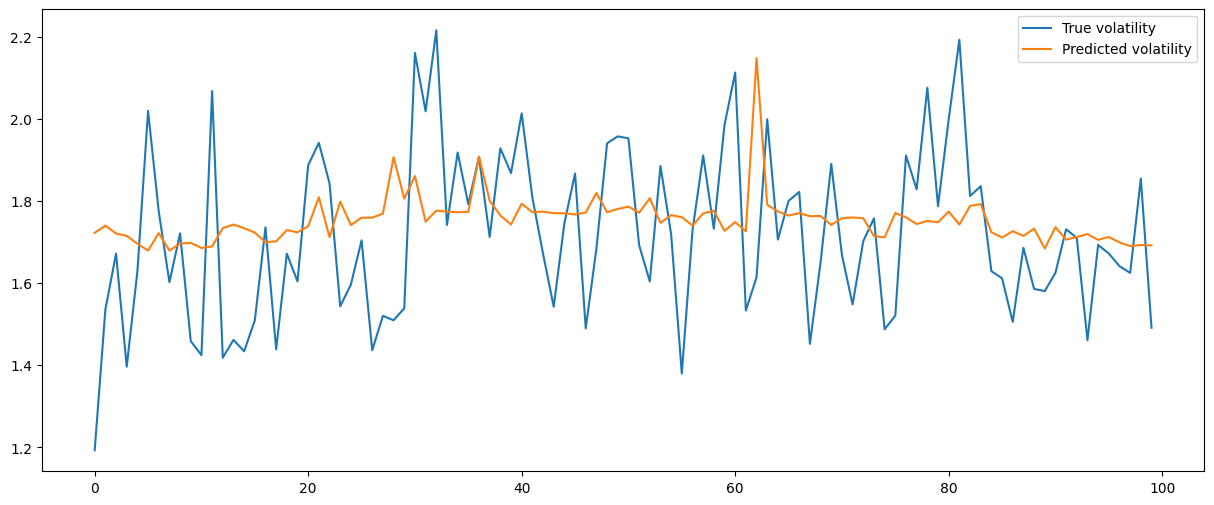

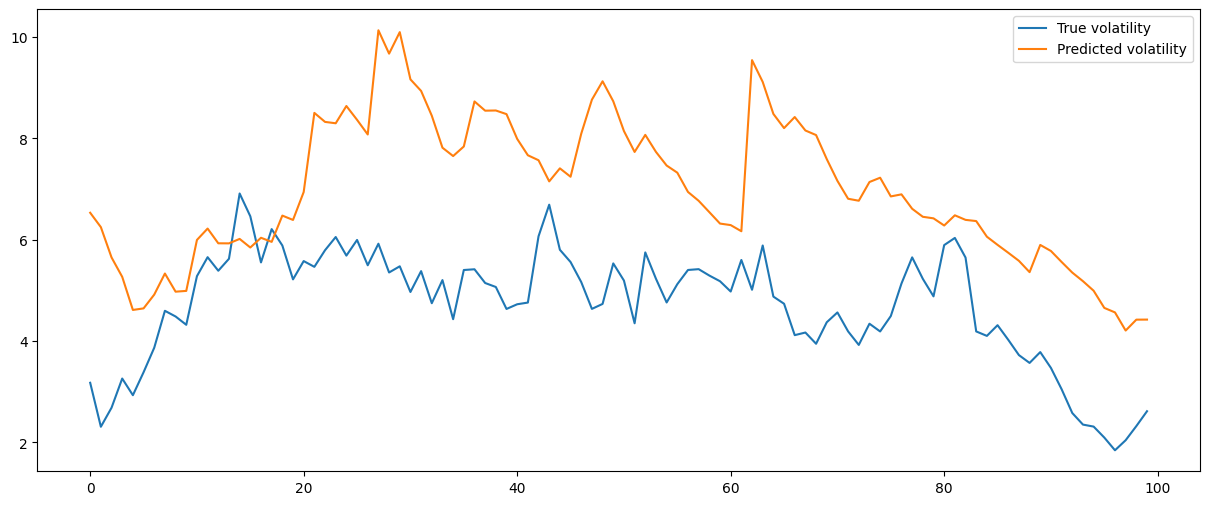

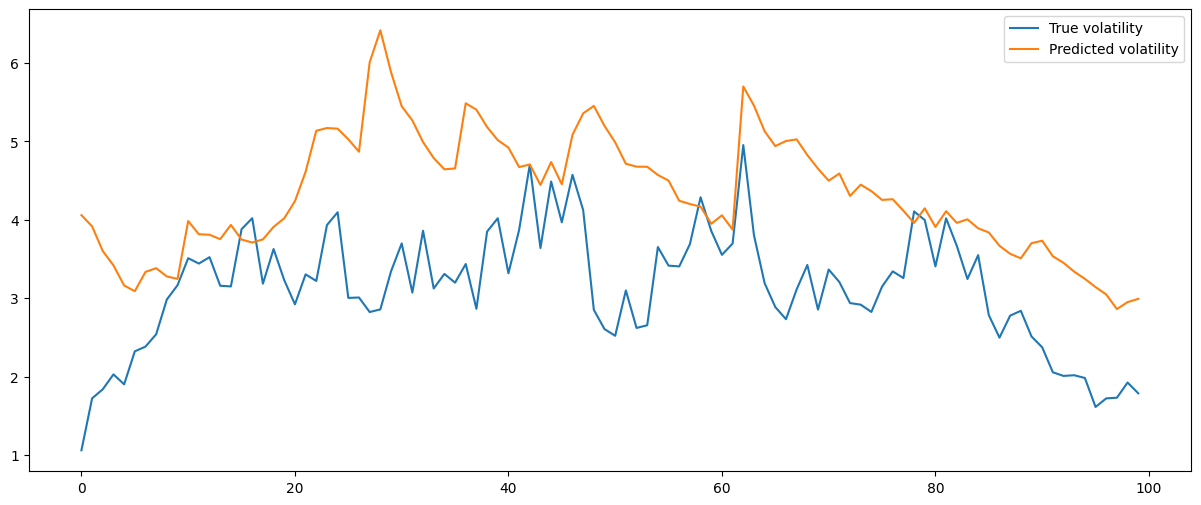

In [21]:
for dim in range(S.shape[1]):
        
    plt.figure(figsize=(15, 6))
    plt.plot(S[:, dim, dim], label="True volatility")
    plt.plot(S_hat[:, dim, dim], label="Predicted volatility")
    plt.legend()
    plt.show()

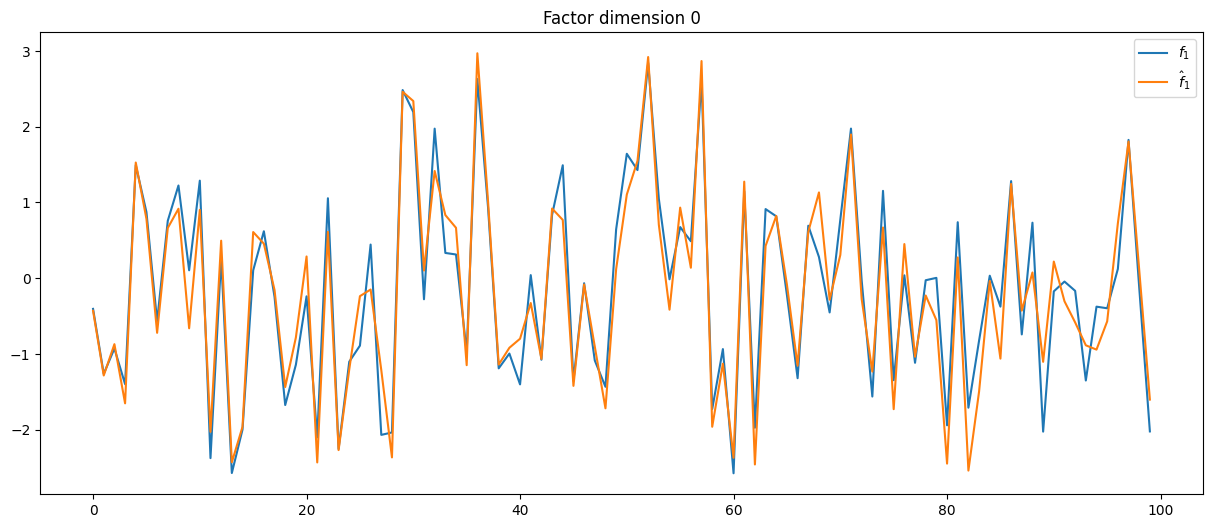

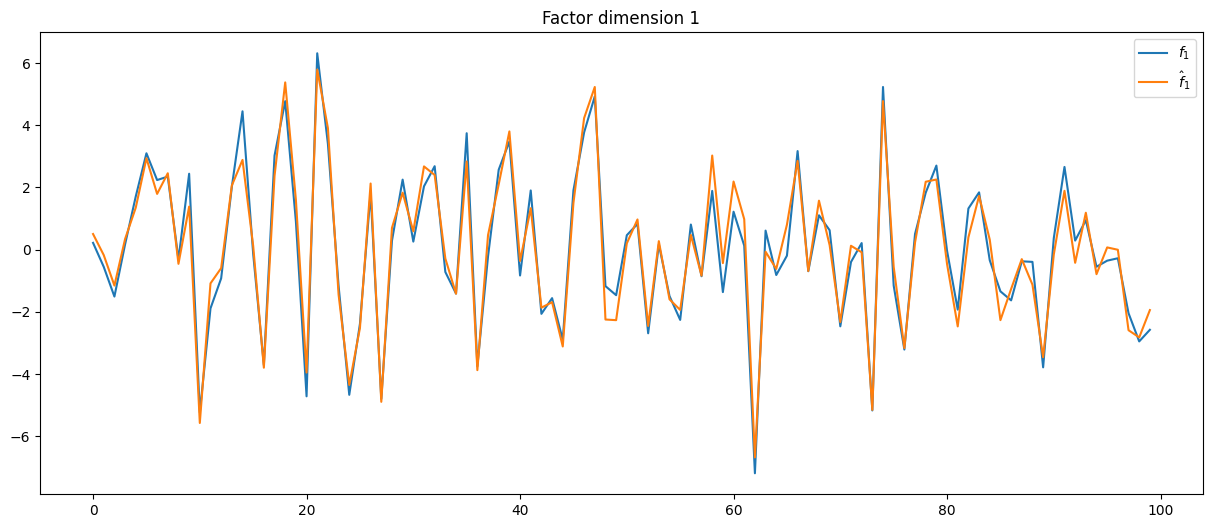

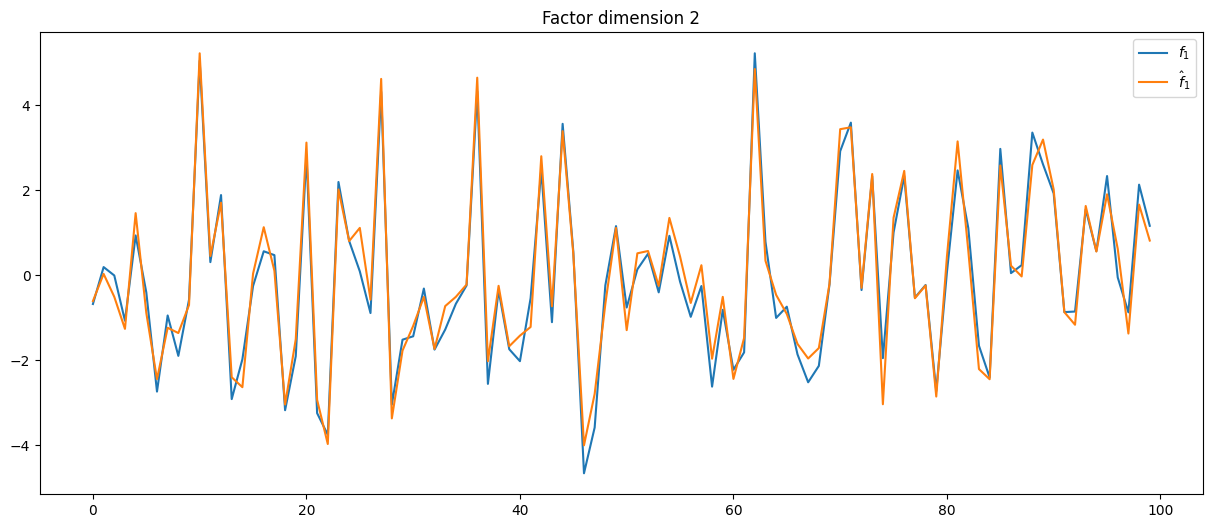

In [22]:
for dim in range(f.shape[1]):
    plt.figure(figsize=(15, 6))
    plt.plot(f[:, dim], label="$f_1$")
    plt.plot(f_hat[:, dim], label=r"$\hat{f}_1$")
    plt.legend()
    plt.title(f"Factor dimension {dim}")
    plt.show()

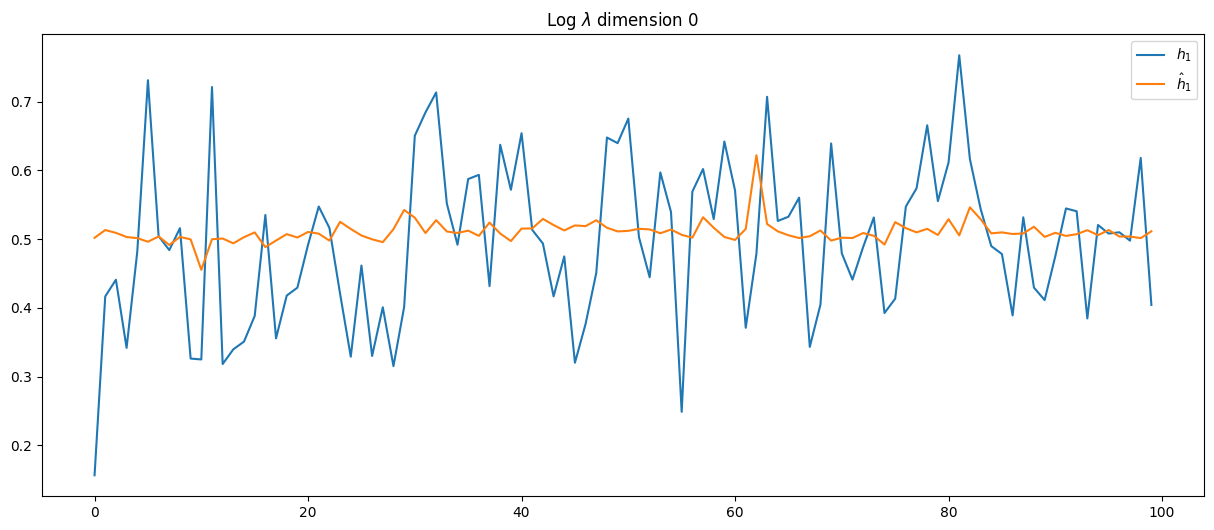

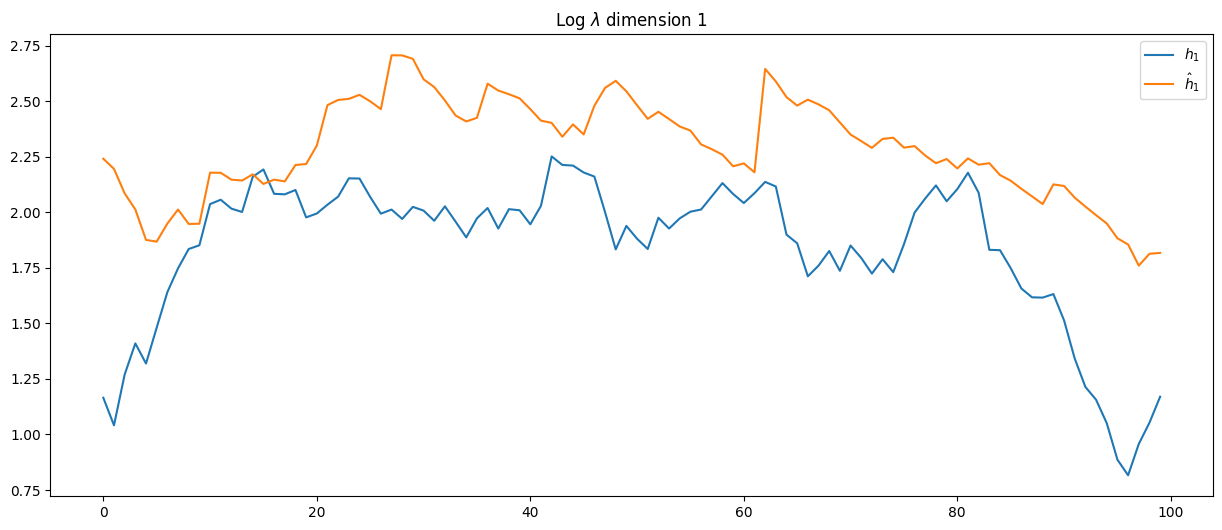

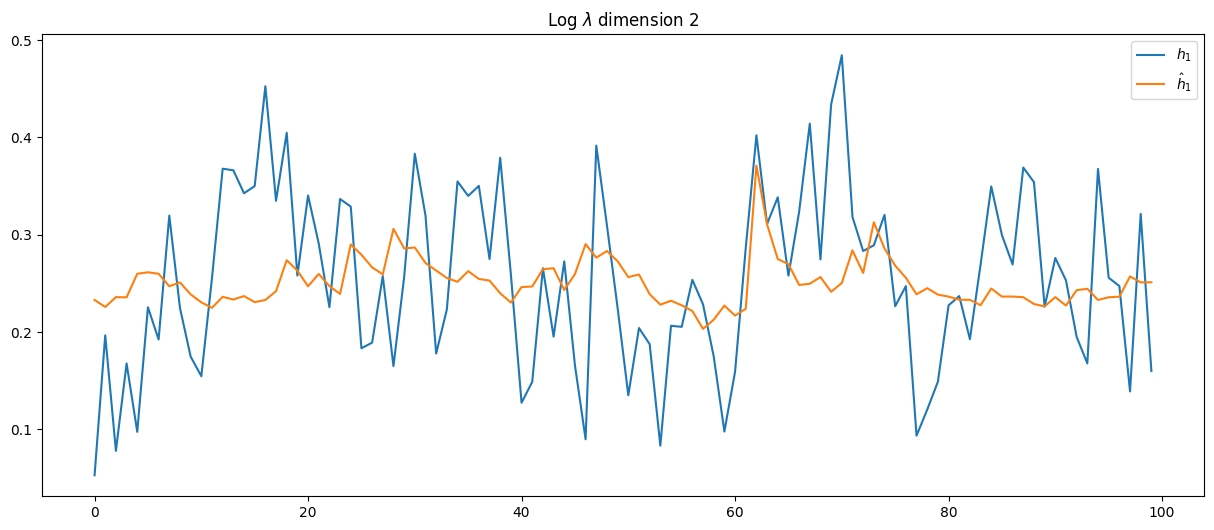

In [23]:
for dim in range(h.shape[1]):
    plt.figure(figsize=(15, 6))
    plt.plot(h[:, dim], label="$h_1$")
    plt.plot(h_hat[:, dim], label=r"$\hat{h}_1$")
    plt.legend()
    plt.title(rf"Log $\lambda$ dimension {dim}")
    plt.show()

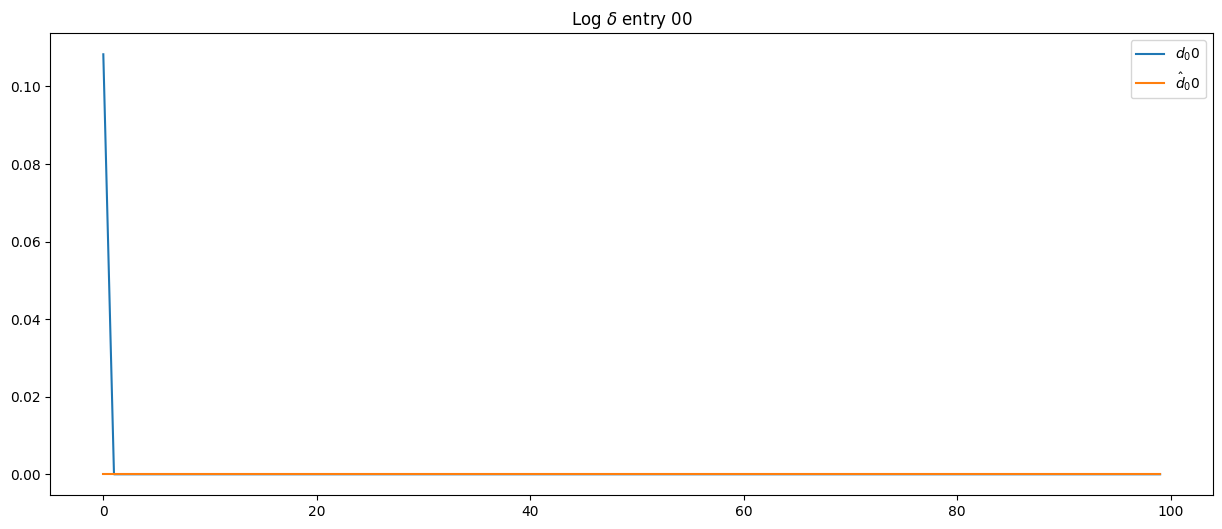

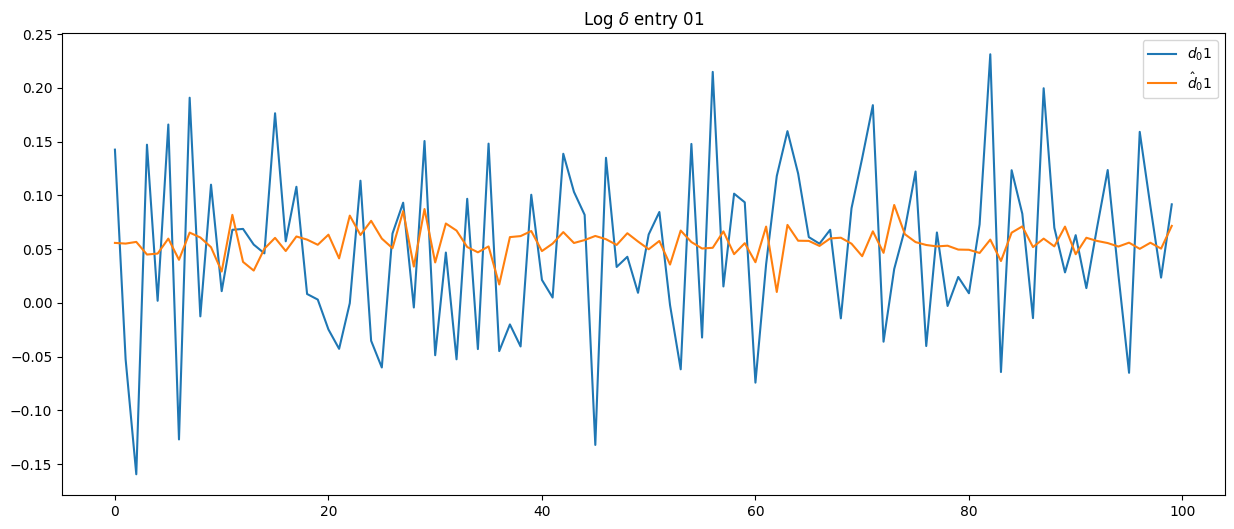

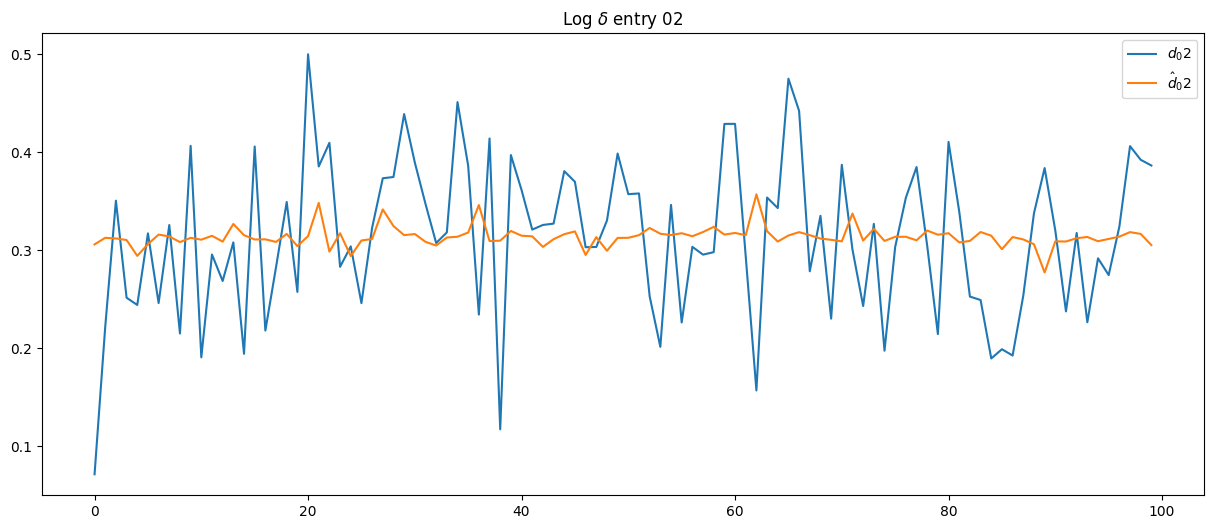

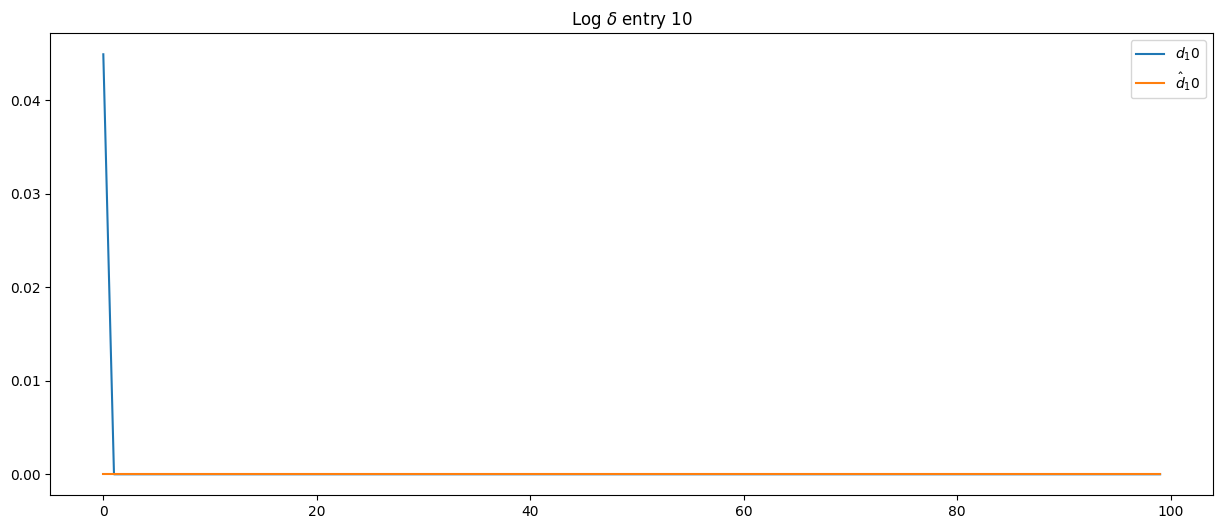

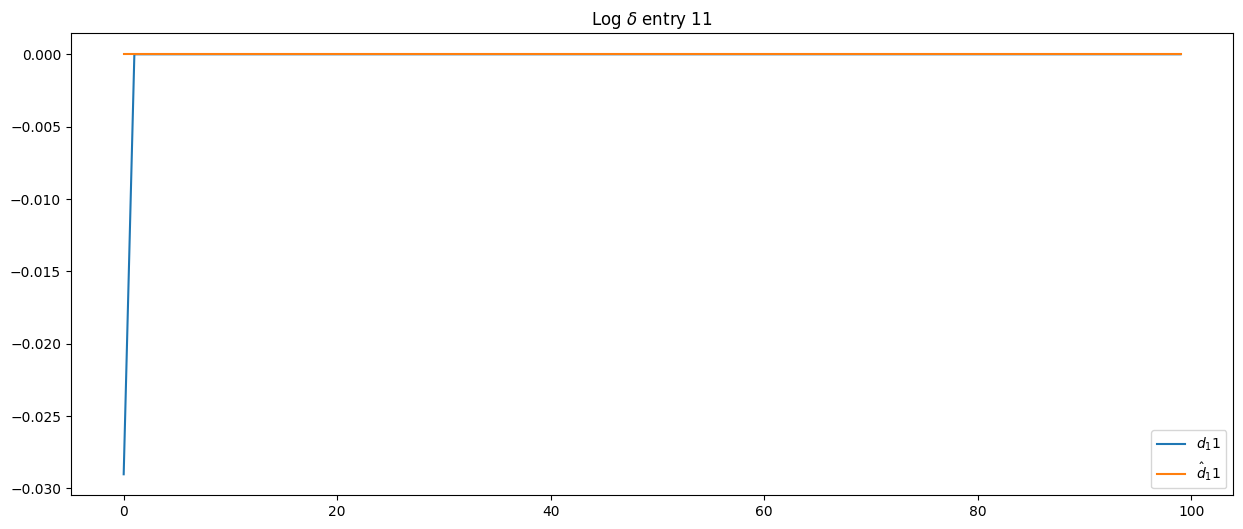

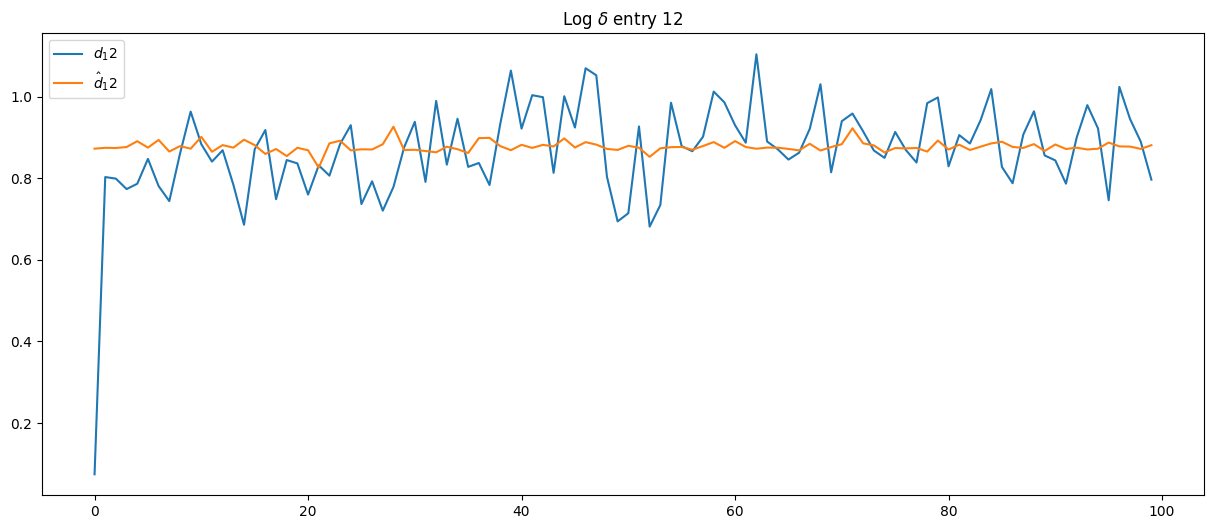

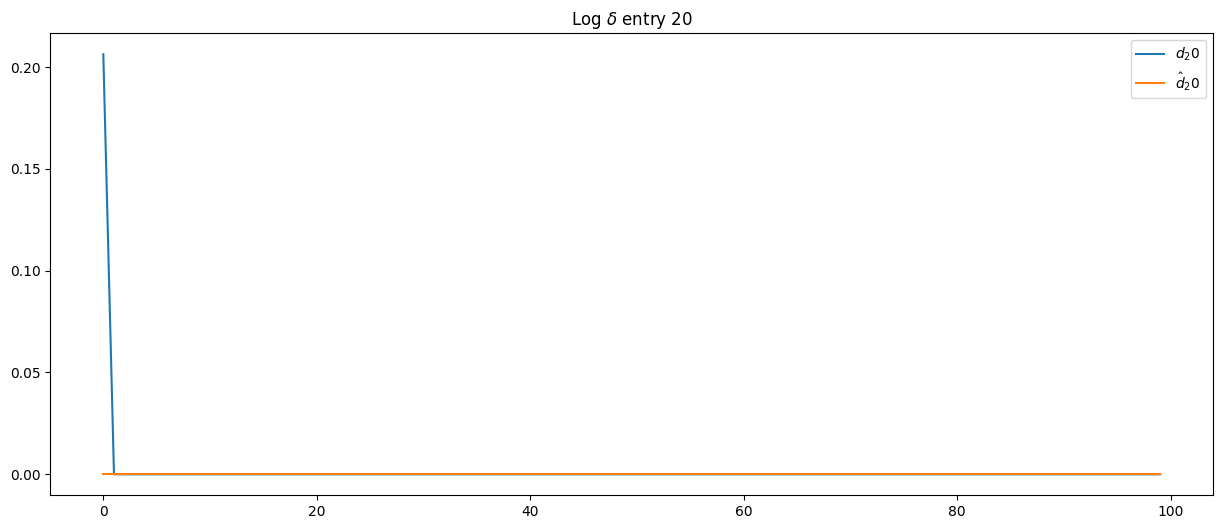

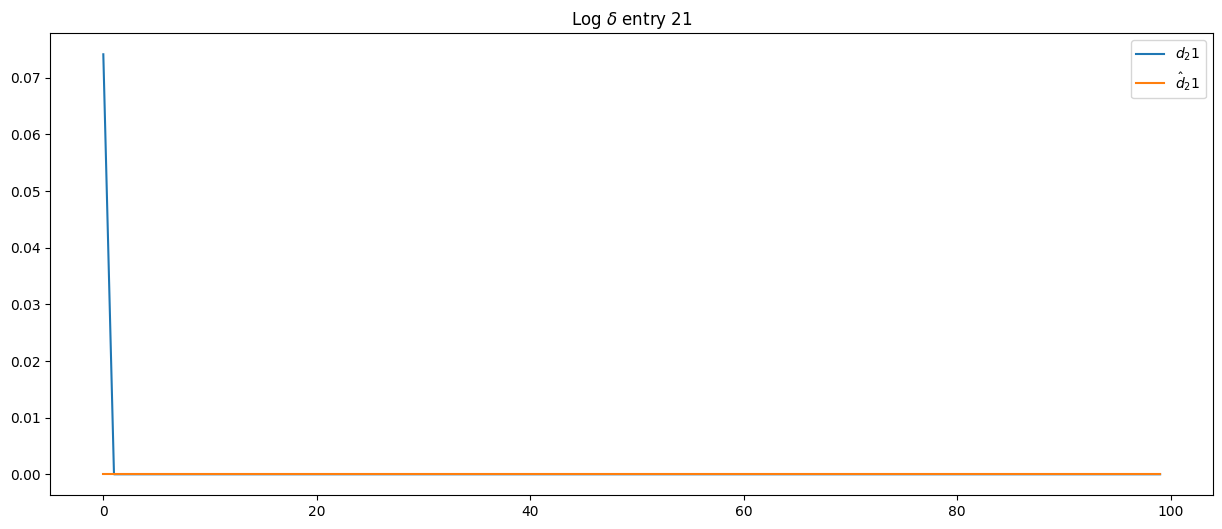

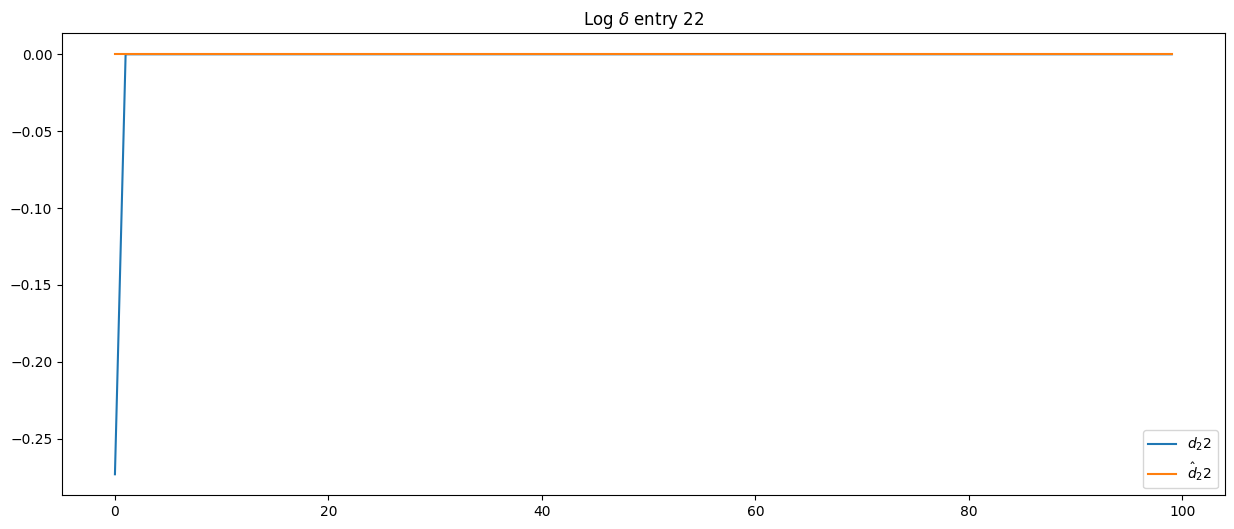

In [24]:
for i in range(d.shape[1]):
    for j in range(d.shape[2]):
        if d[0, i, j] != 0:
                
            plt.figure(figsize=(15, 6))
            plt.plot(d[:, i, j], label=f"$d_{i}{j}$")
            plt.plot(d_hat[:, i, j], label=r"$\hat{d}_"+f"{i}{j}$")
            plt.legend()
            plt.title(rf"Log $\delta$ entry {i}{j}")
            plt.show()